## Lorenz attractor

- decompose the attractor in 4 parts by setting two checkpoints A and B, i.e. plane crossing, corresponding to the two fixed points p1 and p2
- A->A, A->B, B->B and B->A

In [1]:
using DifferentialEquations

In [2]:
using LinearAlgebra

In [488]:
import Plots

In [3]:
# Parameters
const sigma = 10.0
const rho = 28.0
const beta = 8/3.;

# Attractor size
const xy_half_size = 25
const z_size = 45;

voxel_size = z_size/500.0;
const dt = 1. * voxel_size;

In [4]:
# Fixed points
const p1 = [-sqrt(beta*(rho-1)), -sqrt(beta*(rho-1)), rho-1];
const p2 = [+sqrt(beta*(rho-1)), +sqrt(beta*(rho-1)), rho-1];
const u12 = normalize( p2 .- p1 );

In [5]:
function lorenz!(du, u, p, t)
    du[1] = sigma*(u[2]-u[1])
    du[2] = u[1]*(rho-u[3]) - u[2]
    du[3] = u[1]*u[2] - beta*u[3]
    #du = du ./ sqrt(sum(du.^2))  # norm
    normalize!(du)
    end;

# Burn iterations to reach the attractor
function burn()
    u0 = (rand(Float64, 3) .- [0.5, 0.5, 0]).*[2*xy_half_size, 2*xy_half_size, z_size]
    tspan = (0.0, 100.0)
    prob = ODEProblem(lorenz!, u0, tspan)
    tol = 1e-3
    sol = solve(prob, Tsit5(), reltol=tol, abstol=tol,
                save_everystep=false);
    return sol[end]
    end;

In [6]:
burn()

3-element Array{Float64,1}:
 -13.514282103572446
 -14.757209875741184
  32.342980261429325

In [206]:
function checkpoints(out, u, t, integrator)
    a1 = u .- p1
    a2 = u .- p2
    out[1] = -sum(-a1 .* u12)
    out[2] = -sum( a2 .* u12)
end

saved_event_idx = 0
function affect!(integrator, idx)
    global saved_event_idx = idx
    terminate!(integrator)
end
#cb = ContinuousCallback(condition, affect!, rootfind=false);
cb = VectorContinuousCallback(checkpoints, affect!, nothing,
                              2, rootfind=false, save_positions=(true, false));

In [273]:
function burn_to_checkpoint()
    u0 = burn()

    tspan = (0.0, 300.0)
    prob = ODEProblem(lorenz!, u0, tspan)

    global saved_event_idx = 0
    tol = 1e-5
    sol_stop = solve(prob, OwrenZen5(), callback=cb,
                     reltol=tol, abstol=tol,
                     save_everystep=false);

    #println((previous_checkpoint, saved_event_idx))
    return sol_stop.u[end], saved_event_idx
    end;

In [489]:
colors = Dict((1, 1)=>"blue",
          (1, 2)=>"green",
           (2, 1)=>"red", (2, 2)=>"black")

Dict{Tuple{Int64,Int64},String} with 4 entries:
  (1, 2) => "green"
  (2, 2) => "black"
  (1, 1) => "blue"
  (2, 1) => "red"

In [509]:
# init graph
grph = Plots.plot();

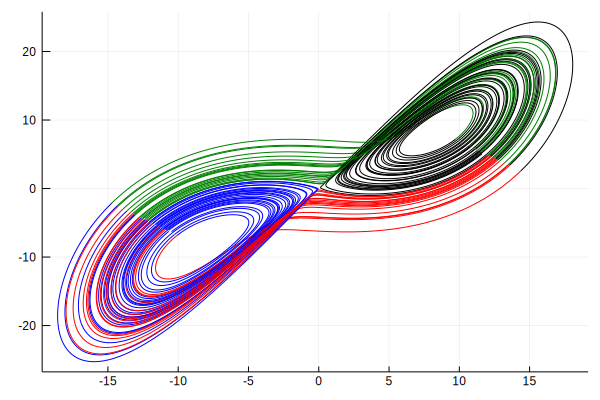

In [510]:

for i in 1:6
    last_u0, previous_checkpoint = burn_to_checkpoint()

    for k in 1:15
        tspan = (0.0, 200.0)
        prob = ODEProblem(lorenz!, last_u0, tspan)


        tol = 1e-8
        sol_stop = solve(prob, OwrenZen5(), callback=cb,
                         reltol=tol, abstol=tol, saveat=dt);

        color = colors[(previous_checkpoint, saved_event_idx)]

        #println((previous_checkpoint, saved_event_idx), color)
        #println(sol_stop.retcode, " - t_end:", sol_stop.t[end])

        delta = sqrt( sum((sol_stop.u[end] .- last_u0).^2) )
        #println(delta)
        last_u0 = sol_stop.u[end]
        previous_checkpoint = saved_event_idx

        x, y, z = (sol_stop[i, :] for i in 1:3)
        Plots.plot!(grph, x, y, color=color, legend=false)
        end;
    end;

grph